In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Model, Input, Sequential
from keras.layers import LSTM, Embedding, DenseFeatures, SpatialDropout1D, Dropout
from keras.layers import Bidirectional, concatenate, TimeDistributed, Dense, Flatten, GlobalMaxPooling1D
from keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.constraints import max_norm
from keras.models import model_from_json

In [2]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)

In [3]:
data = pd.read_csv('/content/drive/MyDrive/NLP/annotatedData.csv', encoding="unicode_escape")
data.head()

,Sent,Word,Tag
0,sent: 0,Bahubali,B-Per
1,sent: 0,2,Other
2,sent: 0,ke,Other
3,sent: 0,liye,Other
4,sent: 0,line,Other


In [4]:
# Filling any null value in sentence with the previously obtained sentence numbers i.e. Forward Fill
data = data.fillna(method="ffill")

In [5]:
# Can be modified
# max_len = 75 # every sentence is max of 75 length
max_len_char = 66 # every word is max of 10 length

In [6]:
# Converting all the tags to B, I, O
tags_dict = {
    'B-Per' : 'B',
    'B-Org' : 'B',
    'B-Loc' : 'B',
    'I-Org' : 'I',
    'I-Loc' : 'I',
    'I-Per' : 'I',
    'Other' : 'O',
}
data.Tag.replace(tags_dict, inplace = True)

In [7]:
# Finding number of unique Words
words = list(set(data["Word"].values))
n_words = len(words)
print('No of unique words =', n_words)

# Finding number of unique Tags
tags = list(set(data["Tag"].values))
n_tags = len(tags);
print('No of unique Tags =', n_tags)

# Finding number of unique Characters
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print('No of unique Characters =', n_chars)

No of unique words = 14866
No of unique Tags = 3
No of unique Characters = 114


In [8]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}

tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0
idx2char = {i : c for i, c in enumerate(char2idx)}

In [9]:
def split_word(word) :
  return [char for char in word]

In [10]:
tagLiFinal =[]
indxLiFinal = []
charLiFinal = []
new_data = pd.DataFrame()
for index, row in data.iterrows(): 
  li = list(row['Word'])
  charlist = split_word(li)
  tagW = row['Tag'] 
  tagLi = []
  indxLi = []
  p = len(li)
  for obj in li:
    indxLi.append(char2idx.get(obj))
    if(tagW == 'B') :
      if p == 1 :
        tagLi.append(tag2idx.get('B'))
      elif p == len(li) :
        tagLi.append(tag2idx.get('B'))
      else :
        tagLi.append(tag2idx.get('I'))
    else :
      tagLi.append(tag2idx.get(tagW))
    p = p - 1
  charLiFinal.extend(charlist)
  indxLiFinal.extend(indxLi)
  tagLiFinal.extend(tagLi)

new_data['Chars'] = charLiFinal
new_data['Tags'] = tagLiFinal

In [11]:
new_data.head(10)
new_data.Chars.replace(char2idx, inplace = True)

In [12]:
def get_pad_train_test_val(data_group):

  pad_tokens = data_group['Chars'].tolist()

  tags = data_group['Tags'].tolist()
  n_tags = len(tag2idx)
  pad_tags = [to_categorical(i, num_classes=n_tags) for i in tags]

  train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.2, random_state=2020)

  return train_tokens, test_tokens, train_tags, test_tags

train_tokens, test_tokens, train_tags, test_tags = get_pad_train_test_val(new_data)

In [13]:
print('Train shape =', len(train_tokens))
print('Train tags shape =', len(train_tags))
print('Test shape =', len(test_tokens))
print('Test tags shape =', len(test_tags))

Train shape = 251633
Train tags shape = 251633
Test shape = 62909
Test tags shape = 62909


In [14]:
def get_bilstm_lstm_model():
  
    model = Sequential()

    model.add(Embedding(input_dim = n_chars + 2, output_dim = 32, input_length = 1))

    model.add(Bidirectional(LSTM(units=20, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    model.add(LSTM(units=20, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
    # model.add(LSTM(units=20, return_sequences=True, dropout=0.6, recurrent_dropout=0.6, kernel_constraint=max_norm(3)))
    
    model.add(Flatten())

    model.add(Dense(len(tag2idx), activation="softmax", kernel_constraint=max_norm(3)))

    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    model.summary()

    return model

In [15]:
model = get_bilstm_lstm_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 32)             3712      
_________________________________________________________________
bidirectional (Bidirectional (None, 1, 40)             8480      
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 20)             4880      
_________________________________________________________________
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 84        
Total params: 17,156
Trainable params: 17,156
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(np.array(train_tokens), np.array(train_tags), batch_size = 512, verbose = 1, epochs = 10, validation_split = 0.2)

Epoch 1/10
394/394 [==============================] - 14s 16ms/step - loss: 0.8253 - accuracy: 0.8705 - val_loss: 0.4082 - val_accuracy: 0.8826
Epoch 2/10
394/394 [==============================] - 6s 14ms/step - loss: 0.4043 - accuracy: 0.8846 - val_loss: 0.4043 - val_accuracy: 0.8826
Epoch 3/10
394/394 [==============================] - 5s 14ms/step - loss: 0.3985 - accuracy: 0.8857 - val_loss: 0.4016 - val_accuracy: 0.8826
Epoch 4/10
394/394 [==============================] - 5s 14ms/step - loss: 0.3986 - accuracy: 0.8848 - val_loss: 0.3962 - val_accuracy: 0.8826
Epoch 5/10
394/394 [==============================] - 5s 14ms/step - loss: 0.3932 - accuracy: 0.8849 - val_loss: 0.3940 - val_accuracy: 0.8836
Epoch 6/10
394/394 [==============================] - 6s 14ms/step - loss: 0.3915 - accuracy: 0.8849 - val_loss: 0.3930 - val_accuracy: 0.8836
Epoch 7/10
394/394 [==============================] - 5s 14ms/step - loss: 0.3910 - accuracy: 0.8852 - val_loss: 0.3926 - val_accuracy: 0.883

In [17]:
score = model.evaluate(np.array(test_tokens), np.array(test_tags), verbose = 1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1] * 100))

1966/1966 [==============================] - 3s 1ms/step - loss: 0.3905 - accuracy: 0.8844
accuracy: 88.44%


In [18]:
y_pred = model.predict([np.array(test_tokens)])

In [19]:
print(y_pred.shape)

(62909, 4)


In [20]:
y_pred.shape
c = 0
for x in y_pred :
  if np.argmax(x) == 2 :
    c = c + 1
print(c)

171


In [21]:
tag2idx

{'B': 2, 'I': 3, 'O': 1, 'PAD': 0}

In [22]:
# For Testing
sent = 'Modi is a bad guy'
words = sent.split(" ")
li = []
for i in words :
  li.extend(split_word(i))
frame = pd.DataFrame()
frame['Chars'] = li
frame.Chars.replace(char2idx, inplace = True)
y = model.predict(np.array(frame['Chars']))
print(y)

[[4.31103725e-03 6.63255095e-01 1.38818324e-01 1.93615571e-01]
 [1.49016341e-05 9.04732466e-01 1.01313200e-02 8.51212889e-02]
 [2.06253462e-04 7.94616342e-01 3.59123759e-02 1.69265091e-01]
 [4.73928449e-05 8.83540750e-01 3.19572128e-02 8.44546035e-02]
 [4.73928449e-05 8.83540750e-01 3.19572128e-02 8.44546035e-02]
 [4.12455483e-05 8.76273274e-01 2.32902188e-02 1.00395307e-01]
 [1.40879083e-05 9.09586012e-01 1.05189895e-02 7.98809081e-02]
 [5.50985578e-06 9.54501092e-01 9.33072809e-03 3.61627489e-02]
 [1.40879083e-05 9.09586012e-01 1.05189895e-02 7.98809081e-02]
 [2.06253462e-04 7.94616342e-01 3.59123759e-02 1.69265091e-01]
 [9.64423452e-06 9.29384708e-01 9.70502291e-03 6.09006844e-02]
 [3.62686587e-05 8.68711829e-01 1.73303820e-02 1.13921508e-01]
 [9.39828897e-06 9.36345816e-01 1.22601483e-02 5.13846762e-02]]


# Character Language Model using both Word and Character Embedding

In [23]:
data = pd.read_csv('/content/drive/MyDrive/NLP/annotatedData.csv', encoding="latin1")
data.head()

,Sent,Word,Tag
0,sent: 0,Bahubali,B-Per
1,sent: 0,2,Other
2,sent: 0,ke,Other
3,sent: 0,liye,Other
4,sent: 0,line,Other


In [24]:
# Filling any null value in sentence with the previously obtained sentence numbers
data = data.fillna(method="ffill")

In [25]:
words = list(set(data["Word"].values))
n_words = len(words)
print('No of unique words =', n_words)

No of unique words = 14866


In [26]:
tags = list(set(data["Tag"].values))
n_tags = len(tags);
print('No of unique Tags =', n_tags)

No of unique Tags = 7


In [27]:
print('No of unique sentences = ', len(data['Sent'].unique()))

No of unique sentences =  3085


In [28]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sent").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [29]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [30]:
# Can be modified
max_len = 75 # every sentence is max of 75 length
max_len_char = 10 # every word is max of 10 length

In [31]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [32]:
X_word = [[word2idx[w[0]] for w in s] for s in sentences]

In [33]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

In [34]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

114


In [35]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [36]:
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [37]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [38]:
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

In [39]:
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, y_char_tr_, y_char_te_ = train_test_split(X_char, y, test_size=0.1, random_state=2018)

In [40]:
# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="relu"))(main_lstm)

model = Model([word_in, char_in], out)

In [41]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75, 10)]     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 75, 10, 10)   1160        input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 75, 20)       297360      input_1[0][0]                    
______________________________________________________________________________________________

In [42]:
history = model.fit([X_word_tr,
                    np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=8, validation_split=0.1, verbose=1)

Epoch 1/8
79/79 [==============================] - 29s 265ms/step - loss: 0.3457 - accuracy: 0.8636 - val_loss: 0.2171 - val_accuracy: 0.9204
Epoch 2/8
79/79 [==============================] - 20s 253ms/step - loss: 0.1629 - accuracy: 0.9292 - val_loss: 0.1581 - val_accuracy: 0.9204
Epoch 3/8
79/79 [==============================] - 20s 250ms/step - loss: 0.1153 - accuracy: 0.9275 - val_loss: 0.1485 - val_accuracy: 0.9213
Epoch 4/8
79/79 [==============================] - 20s 250ms/step - loss: 0.0953 - accuracy: 0.9283 - val_loss: 0.2087 - val_accuracy: 0.9205
Epoch 5/8
79/79 [==============================] - 20s 251ms/step - loss: 0.1560 - accuracy: 0.9288 - val_loss: 0.1108 - val_accuracy: 0.9207
Epoch 6/8
79/79 [==============================] - 20s 250ms/step - loss: 0.0846 - accuracy: 0.9284 - val_loss: 0.1014 - val_accuracy: 0.9225
Epoch 7/8
79/79 [==============================] - 20s 252ms/step - loss: 0.0559 - accuracy: 0.9321 - val_loss: 0.1041 - val_accuracy: 0.9310
Epoch 

In [43]:
hist = pd.DataFrame(history.history)

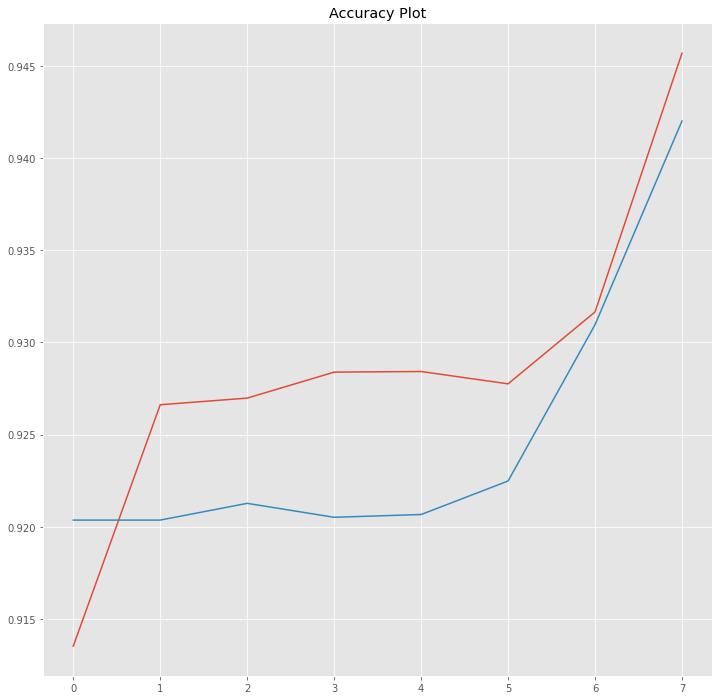

In [57]:
# Plotting the accuracy between training accuracy and validation accuracy
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title('Accuracy Plot')
plt.show()

In [45]:
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])

In [55]:
i = 150
p = np.argmax(y_pred[i], axis=-1)
print("{:20}||{:30}||{}".format("Word", "Ground Truth", "Predcted Labels"))
print(75 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != 0:
        print("{:20}: {:30} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

Word                ||Ground Truth                  ||Predcted Labels
Modiji              : B-Per                          B-Per
jawab               : Other                          Other
de                  : Other                          Other
#Dhoni              : B-Per                          B-Per
ne                  : Other                          Other
retirement          : Other                          Other
kyu                 : Other                          Other
li                  : Other                          Other
hai                 : Other                          Other
?                   : Other                          Other
Varna               : Other                          Other
me                  : Other                          Other
pure                : Other                          Other
bharat              : B-Loc                          Other
me                  : Other                          Other
ghum                : Other                  

In [47]:
# Checking the accuracy score on the test data separated out
scores = model.evaluate([X_word_te,
                    np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))], 
                    np.array(y_te).reshape(len(y_char_te_), max_len, 1), verbose = 0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

accuracy: 94.63%
